<a href="https://colab.research.google.com/github/Gab2697/Surface-classification-EMG-IMU/blob/main/CNN/SUBJECT_WISE_VS_NOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import and functions

In [1]:
#import
import pandas as pd
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.io import loadmat

from keras import layers 
from keras import models
from keras import regularizers
import glob

from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
#================================Open pickle file================================
def open_pickle(path_pickle):
    f = open(path_pickle, 'rb')
    T = pickle.load(f)
    f.close()

    return T

#================================Seperate signals from IMU================================
def seperate_IMU_signals(type_signal,ALL_data):
  if type_signal=='gyro':
    ALL_data=ALL_data[:,:,0:36]
  # elif type_signal=='angle':
  #   ALL_data=ALL_data[:,:,37:75]
  elif type_signal=='acc':
    ALL_data=ALL_data[:,:,36:83]
  elif type_signal=='EMG_raw':
    ALL_data=ALL_data[:,:,83:88]
  elif type_signal=='EMG_HF':
    ALL_data=ALL_data[:,:,88:92]
  elif type_signal=='EMG_LF':
    ALL_data=ALL_data[:,:,92:96]
  elif type_signal=='EMG_rectified':
    ALL_data=ALL_data[:,:,96:100]
  elif type_signal=='EMG_rms':
    ALL_data=ALL_data[:,:,100:104]
  elif type_signal=='EMG_Env':
    ALL_data=ALL_data[:,:,104:108]
  return ALL_data

#================================subject wise split================================
def subject_wise_split(Participant,subject_wise,split=0.10,seed=42):
    np.random.seed(seed)
    if subject_wise:
        UniqParti=np.unique(Participant)
        num=np.round(UniqParti.shape[0]*split).astype('int64')
        np.random.shuffle(UniqParti)
        extract=UniqParti[0:num]
        test_index=np.array([],dtype='int64')
        for j in extract:
            test_index=np.append(test_index,np.where(Participant==j)[0])
        train_index=np.delete(np.arange(len(Participant)),test_index)
        np.random.shuffle(test_index)
        np.random.shuffle(train_index)

    else:
        I=np.arange(len(Participant)).astype('int64')
        np.random.shuffle(I)
        num=np.round(Participant.shape[0]*split).astype('int64')
        test_index=I[0:num]
        train_index=I[num:]
        extract=np.unique(Participant[test_index])
    return train_index,test_index,extract

#================================One Hot encoding================================
def one_hot(y):
    uniq=np.unique(y)
    y_hot=np.zeros([y.shape[0],uniq.shape[0]])
    for i in range(len(uniq)):
        index=np.where(y==uniq[i])[0]
        y_hot[index,i]=1
    surface_name=uniq
    return y_hot

#================================final prep CNN================================
def final_prep(data, Surface, Participant, yes_no):
  #test set
  train_index1,test_index,extract=subject_wise_split(np.array(Participant),split=0.20,subject_wise= yes_no,seed=5)
  train_index1,test_index=train_index1.astype('int64'),test_index.astype('int64')   
  X_train1=data[train_index1]
  X_test=data[test_index]
  y_train1=Surface[train_index1]
  y_test=Surface[test_index]

  #validation set
  ALL_Participants_train=ALL_Participants_numb_NS[train_index1]
  train_index,validation_index,extract=subject_wise_split(np.array(ALL_Participants_train),split=0.30,subject_wise= yes_no,seed=5)
  train_index,validation_index=train_index.astype('int64'),validation_index.astype('int64')  
  X_train=X_train1[train_index]
  X_validation=X_train1[validation_index]
  y_train=y_train1[train_index]
  y_validation=y_train1[validation_index]

  #tensor shape
  print("Tensor train emg raw shape:", X_train.shape)
  print("Tensor validation emg raw shape:", X_validation.shape)
  print("Tensor test emg raw shape:", X_test.shape)

  #one hot encoding for label
  X_train=np.asarray(X_train).astype(np.float32) 
  y_train=one_hot(y_train)
  X_test=np.asarray(X_test).astype(np.float32) 
  y_test=one_hot(y_test)
  X_validation=np.asarray(X_validation).astype(np.float32)
  y_validation=one_hot(y_validation)
  return X_train,y_train,X_test,y_test,X_validation, y_validation
#-----------------------------------------
def final_prep1(data, Surface, Participant, yes_no):
  #test set
  train_index,test_index,extract=subject_wise_split(np.array(Participant),split=0.20,subject_wise= yes_no,seed=5)
  train_index,test_index=train_index.astype('int64'),test_index.astype('int64')   
  X_train=data[train_index]
  X_test=data[test_index]
  y_train=Surface[train_index]
  y_test=Surface[test_index]


  #one hot encoding for label
  X_train=np.asarray(X_train).astype(np.float32) 
  y_train=one_hot(y_train)
  X_test=np.asarray(X_test).astype(np.float32) 
  y_test=one_hot(y_test)
  return X_train,y_train,X_test,y_test

#================================ CNN================================
def make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt):
  #Instantiating convnet
  model = models.Sequential()
  model.add(layers.Conv1D(filter_numb1, kernel_size,activation='relu', input_shape=(input_size),padding='same')) 
  model.add(layers.Conv1D(filter_numb2, kernel_size, activation='relu',padding='same'))
  #Adding a classifier on top of the convnet
  model.add(layers.Flatten()) 
  model.add(layers.Dense(filter_numb3, activation='relu')) 
  model.add(layers.Dense(2, activation='softmax')) 
  # model.summary()
  model.compile(optimizer = opt, loss='binary_crossentropy', metrics=['accuracy']) 
  return model 

#GC_NS_BASED ON MERGE DATA

In [4]:
#open pickle
ALL_data_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_data_NS.pkl')
ALL_Surfaces_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Surfaces_NS.pkl')
ALL_Participants_numb_NS=open_pickle('/content/drive/MyDrive/Gab/Variables_saved/IMU/ALL_Participants_numb_NS.pkl')

## EMG_RAW

SPLIT SUBJECT-WISE

In [18]:
ALL_data_emg_raw=seperate_IMU_signals('EMG_raw',ALL_data_NS)
print("Tensor all emg raw shape:", ALL_data_emg_raw.shape)
#seperate train,validation and test set for EMG raw data 
# X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_emg_raw, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),True)

X_train,y_train,X_test,y_test=final_prep1(ALL_data_emg_raw, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),True)

Tensor all emg raw shape: (11181, 101, 5)


In [19]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
# make_model_1D(input_size,filter_numb1,filter_numb2,filter_numb3,kernel_size,pool_size,opt)
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/100
47/47 [==============================] - 5s 84ms/step - loss: 1.4506 - accuracy: 0.5388 - val_loss: 0.6916 - val_accuracy: 0.5876
Epoch 2/100
47/47 [==============================] - 4s 80ms/step - loss: 0.6670 - accuracy: 0.6009 - val_loss: 0.7070 - val_accuracy: 0.5182
Epoch 3/100
47/47 [==============================] - 4s 82ms/step - loss: 0.6355 - accuracy: 0.6449 - val_loss: 0.6909 - val_accuracy: 0.5323
Epoch 4/100
47/47 [==============================] - 4s 80ms/step - loss: 0.5823 - accuracy: 0.7023 - val_loss: 0.6993 - val_accuracy: 0.6620
Epoch 5/100
47/47 [==============================] - 4s 88ms/step - loss: 0.5465 - accuracy: 0.7345 - val_loss: 0.8178 - val_accuracy: 0.5426
Epoch 6/100
47/47 [==============================] - 5s 106ms/step - loss: 0.4942 - accuracy: 0.7668 - val_loss: 0.7796 - val_accuracy: 0.5638
Epoch 7/100
47/47 [==============================] - 4s 81ms/step - loss: 0.4516 - accuracy: 0.7896 - val_loss: 0.7626 - val_accuracy: 0.6099
Epoch

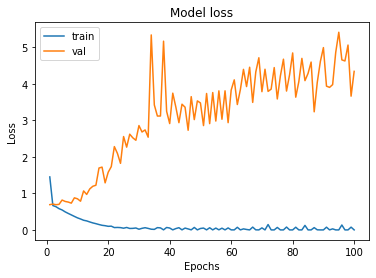

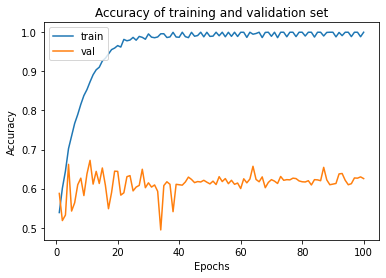

In [20]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

SPLIT NOT SUBJECT-WISE (SHUFFLED IN VALIDATION AND TRAINING)

In [21]:
ALL_data_emg_raw=seperate_IMU_signals('EMG_raw',ALL_data_NS)
print("Tensor all emg raw shape:", ALL_data_emg_raw.shape)
#seperate train,validation and test set for EMG raw data 
X_train,y_train,X_test,y_test=final_prep1(ALL_data_emg_raw, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),False)

Tensor all emg raw shape: (11181, 101, 5)


In [22]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001)) 
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_test, y_test))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


45/45 [==============================] - 5s 87ms/step - loss: 1.1189 - accuracy: 0.5570 - val_loss: 0.6970 - val_accuracy: 0.5756
Epoch 2/100
45/45 [==============================] - 4s 81ms/step - loss: 0.6513 - accuracy: 0.6259 - val_loss: 0.6196 - val_accuracy: 0.6775
Epoch 3/100
45/45 [==============================] - 4s 81ms/step - loss: 0.6072 - accuracy: 0.6709 - val_loss: 0.6986 - val_accuracy: 0.6140
Epoch 4/100
45/45 [==============================] - 4s 81ms/step - loss: 0.5599 - accuracy: 0.7193 - val_loss: 0.6087 - val_accuracy: 0.6981
Epoch 5/100
45/45 [==============================] - 4s 81ms/step - loss: 0.5139 - accuracy: 0.7447 - val_loss: 0.5598 - val_accuracy: 0.7330
Epoch 6/100
45/45 [==============================] - 4s 81ms/step - loss: 0.4633 - accuracy: 0.7904 - val_loss: 0.6204 - val_accuracy: 0.7062
Epoch 7/100
45/45 [==============================] - 4s 81ms/step - loss: 0.4346 - accuracy: 0.8008 - val_loss: 0.5353 - val_accuracy: 0.7563
Epoch 8/100
45/45 

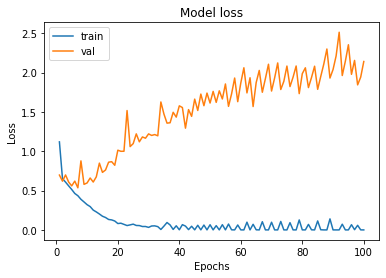

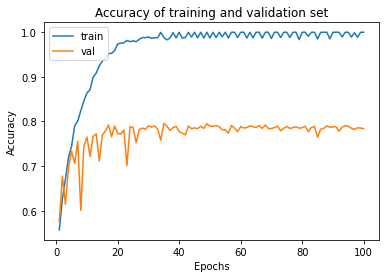

In [23]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## GYRO-MERGE IMU_EMG GC

GYRO SPLIT SUBJECT WISE

FIGURE OUT IF THERE IS A PROBLEM WITH THE VALIDATION SET--DIFFERENT SIZES

In [ ]:
ALL_data_gyro=seperate_IMU_signals('gyro',ALL_data_NS)
print("Tensor all gyro shape:", ALL_data_gyro.shape)
#seperate train,validation and test set for gyro 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_gyro, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),True)

In [ ]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

GYRO SPLIT NOT SUBJECT WISE

In [ ]:
ALL_data_gyro=seperate_IMU_signals('gyro',ALL_data_NS)
print("Tensor all gyro shape:", ALL_data_gyro.shape)
#seperate train,validation and test set for gyro 
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_gyro, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),False)

In [ ]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## ACC- MERGE_IMU_EMG_GC

ACC- SPLIT SUBJECT WISE

In [16]:
ALL_data_acc=seperate_IMU_signals('acc',ALL_data_NS)
print("Tensor all acc shape:", ALL_data_acc.shape)
#seperate train,validation and test set for acc
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_acc, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),True)

Tensor all acc shape: (11181, 101, 47)
Tensor train emg raw shape: (6506, 101, 47)
Tensor validation emg raw shape: (2832, 101, 47)
Tensor test emg raw shape: (1843, 101, 47)


In [ ]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

ACC- SPLIT NOT SUBJECT WISE

In [ ]:
ALL_data_acc=seperate_IMU_signals('acc',ALL_data_NS)
print("Tensor all acc shape:", ALL_data_acc.shape)
#seperate train,validation and test set for acc
X_train,y_train,X_test,y_test,X_validation, y_validation=final_prep(ALL_data_acc, ALL_Surfaces_NS.to_numpy(), ALL_Participants_numb_NS.to_numpy(),False)

In [ ]:
model=make_model_1D(X_train.shape[1:],64,64,100,3,2,RMSprop(lr=0.001))
history= model.fit(X_train,y_train, epochs=100, batch_size=200,validation_data=(X_validation, y_validation))

In [ ]:
#plot train/validation loss and train/validation accuracy 
history_dict = history.history
loss_values=history_dict['loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs,history_dict['loss'])
plt.plot(epochs, history_dict['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

accuracy_values = history_dict['accuracy']
val_accuracy= history_dict['val_accuracy']
plt.plot(epochs, accuracy_values)
plt.plot(epochs, val_accuracy)
plt.title('Accuracy of training and validation set') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#GC_NS_BASED ON ONLY IMU

## ACC

## GYRO